# Analysis of 3k T cells from cancer

In [1]:
import warnings
warnings.filterwarnings("ignore")
import muon as mu
import numpy as np
import scanpy as sc
import scirpy as ir
from cycler import cycler
from matplotlib import cm as mpl_cm
from matplotlib import pyplot as plt
from mudata import MuData
sc.set_figure_params(figsize=(4, 4))
sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)

In [2]:
sc.logging.print_header()

scanpy==1.10.2 anndata==0.11.3 umap==0.5.6 numpy==1.26.4 scipy==1.11.1 pandas==2.2.3 scikit-learn==1.3.0 statsmodels==0.14.0 igraph==0.11.8 louvain==0.8.2 pynndescent==0.5.13


## Importing data

In [3]:
%cd /ihome/ylee/yiz133/Code/Scirpy/scripy/data

/ihome/ylee/yiz133/Code/Scirpy/scripy/data


In [4]:
dates = ["0516_","0605_"]
tissue = ["CNS", "SPL"]
adatas_tcr = {}
adatas_gex = {}

for D in dates:
    for T in tissue:
        sample = D+T 
        adata_tcr = ir.io.read_10x_vdj(
            sample + "_filtered_contig_annotations.csv"
        )
        
        # Load the associated transcriptomics data
        adata_gex = sc.read_10x_h5(
            sample + "_sample_filtered_feature_bc_matrix.h5", gex_only = False
        )
        adata_gex.var_names_make_unique()
        adata_df = adata_gex.to_df()
        
        df2 = adata_df.filter(regex='CMO')
        df2['mouse_id'] = df2.idxmax(axis=1)
        adata_gex.obs["mouse_id"] = df2['mouse_id']

        adata_gex.obs["date"] = D[:-1]
        adata_gex.obs["tissue"] = T[:-1]
        
        adata_gex.obs.index = adata_gex.obs.index + "_" + sample
        adata_tcr.obs.index = adata_tcr.obs.index + "_" + sample
    
        adatas_gex[sample] = adata_gex
        adatas_tcr[sample] = adata_tcr
        
        print(f"Loaded {sample}: GEX shape {adata_gex.shape}, TCR shape {adata_tcr.shape}")
        

reading 0516_CNS_sample_filtered_feature_bc_matrix.h5
 (0:00:00)
Loaded 0516_CNS: GEX shape (4780, 33708), TCR shape (2637, 0)
reading 0516_SPL_sample_filtered_feature_bc_matrix.h5
 (0:00:02)
Loaded 0516_SPL: GEX shape (34423, 33708), TCR shape (28337, 0)
reading 0605_CNS_sample_filtered_feature_bc_matrix.h5
 (0:00:02)
Loaded 0605_CNS: GEX shape (27799, 33708), TCR shape (15058, 0)
reading 0605_SPL_sample_filtered_feature_bc_matrix.h5
 (0:00:02)
Loaded 0605_SPL: GEX shape (39433, 33708), TCR shape (31628, 0)


In [5]:
import anndata
adata_gex = anndata.concat(adatas_gex, index_unique=None)  # Merge GEX
adata_tcr = anndata.concat(adatas_tcr, index_unique=None)  # Merge TCR

In [6]:
##### load data
# adata_gex.write("all_gex.h5ad")
# adata_tcr.write("all_tcr.h5ad")

adata_gex = sc.read("all_gex.h5ad")
adata_tcr = sc.read("all_tcr.h5ad")

mdata = mu.MuData({"gex": adata_gex, "airr": adata_tcr})
mdata.obs

,gex:mouse_id,gex:date,gex:tissue
AAACCAAAGGGGAGCT-1_0516_CNS,CMO318,0516,CN
AAACCAAAGGTCGACT-1_0516_CNS,CMO325,0516,CN
AAACCAGCACGTAAAG-1_0516_CNS,CMO318,0516,CN
AAACCATTCACTACTC-1_0516_CNS,CMO325,0516,CN
AAACCATTCCTCCGGT-1_0516_CNS,CMO325,0516,CN
...,...,...,...
GTTGTGGGTGGATCGC-1_0605_SPL,CMO304,0605,SP
GTTGTGGGTGGCTGTA-1_0605_SPL,CMO301,0605,SP
GTTGTGGGTGGTCCCC-1_0605_SPL,CMO301,0605,SP
GTTGTGGGTGTCCCTG-1_0605_SPL,CMO302,0605,SP


In [7]:
adata_tcr.obsm['airr'][0]

<Array [{c_call: 'TRBC2', cdr1: ..., ...}, ...] type='2 * {c_call: ?string,...'>

In [8]:
ir.pp.index_chains(adata_tcr) 
adata_tcr

Filtering chains...
Indexing VJ chains...
Indexing VDJ chains...
build result array


AnnData object with n_obs × n_vars = 77660 × 0
    uns: 'chain_indices'
    obsm: 'airr', 'chain_indices'

In [9]:
adata_tcr.obsm["chain_indices"][0]

<Record {VJ: [1, None], VDJ: [...], ...} type='{VJ: 2 * ?int64, VDJ: 2 * ?i...'>

In [10]:
VJ_AA_DF = ir.get.airr(adata_tcr, "cdr3_aa", "VJ_1")
VJ_AA_DF

cell_id
AAACCAAAGGGGAGCT-1_0516_CNS          AAANNRIF
AAACCAGCACGTAAAG-1_0516_CNS     ALSAGTGNTGKLI
AAACCATTCCTCCGGT-1_0516_CNS     AMREGTTGYQNFY
AAACCCATCAGTATCG-1_0516_CNS         AVRNYNVLY
AAACCCCAGCCTAAGC-1_0516_CNS      AVSPNTGYQNFY
                                    ...      
GTTGTGGGTGGAGCGA-1_0605_SPL      AASTSSGSWQLI
GTTGTGGGTGGATCGC-1_0605_SPL      ALGDDTGYQNFY
GTTGTGGGTGGCTGTA-1_0605_SPL      ALDLNTGYQNFY
GTTGTGGGTGTCCCTG-1_0605_SPL        ALTASLGKLQ
GTTGTGGGTGTTACCC-1_0605_SPL    AVRRNTGGLSGKLT
Length: 77660, dtype: object

In [11]:
# Get common cell indices between gex and airr
common_cells = mdata.mod["gex"].obs.index.intersection(mdata.mod["airr"].obs.index)

# Subset gex to only include these cells
gex_subset = mdata.mod["gex"][common_cells, :].copy()

tcr_subset = mdata.mod["airr"][common_cells, :].copy()

# Create a new MuData object to preserve alignment
mdata_new = mu.MuData({"gex": gex_subset, "airr": tcr_subset})

# Copy previous metadata from the old mdata object
mdata_new.obs = mdata.obs.loc[mdata_new.mod["gex"].obs.index]

# Verify the new object
print(mdata_new)

MuData object with n_obs × n_vars = 77660 × 33708
  2 modalities
    gex:	77660 x 33708
      obs:	'mouse_id', 'date', 'tissue'
    airr:	77660 x 0
      uns:	'chain_indices'
      obsm:	'airr', 'chain_indices'


In [12]:
import pandas as pd
metadata_paths = {
    "CNS": "CNS_cell_type_annotation.csv",
    "SPL": "Spleen_cell_type_annotation.csv"
}

# Read metadata files
metadata_list = []
for tissue, path in metadata_paths.items():
    meta = pd.read_csv(path, index_col=0)  # Ensure the first column is treated as the index

    # Extract run number from the index (barcode) → `_1` means "0516", `_2` means "0605"
    meta["run_num"] = meta.index.to_series().str.split("_").str[-1].map({"1": "0516", "2": "0605"})

    # Create the correct barcode format: "AAACCAAAGGGGAGCT-1_CNS_0605"
    meta["barcode"] = meta.index.to_series().str.replace("_1", "", regex=False).str.replace("_2", "", regex=False)
    meta["barcode"] = meta["barcode"] + "_" + meta["run_num"] + "_" + tissue

    metadata_list.append(meta)

# Combine metadata from both CNS and Spleen
metadata = pd.concat(metadata_list, ignore_index=False)  # Keep original index

# Merge metadata with `mdata.obs`
mdata.obs = mdata.obs.merge(metadata, left_index=True, right_on="barcode", how="left")

# Set the index to the barcode column for consistency
mdata.obs.set_index("barcode", inplace=True)


## Get common cell indices between gex and airr

In [13]:
common_cells = mdata.mod["gex"].obs.index.intersection(mdata.mod["airr"].obs.index)

# Subset gex to only include these cells
gex_subset = mdata.mod["gex"][common_cells, :].copy()
tcr_subset = mdata.mod["airr"][common_cells, :].copy()
# Create a new MuData object to preserve alignment
mdata_new = mu.MuData({"gex": gex_subset, "airr": tcr_subset})

# Copy previous metadata from the old mdata object
mdata_new.obs = mdata.obs.loc[mdata_new.mod["gex"].obs.index]

# Verify the new object
print(mdata_new)

MuData object with n_obs × n_vars = 77660 × 33708
  obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'integrated_nn_res.2', 'seurat_clusters', 'level_2_clusters', 'manual_cell_type', 'run_num'
  2 modalities
    gex:	77660 x 33708
      obs:	'mouse_id', 'date', 'tissue'
    airr:	77660 x 0
      uns:	'chain_indices'
      obsm:	'airr', 'chain_indices'


In [14]:
mdata_new.obs

,gex:mouse_id,gex:date,gex:tissue,orig.ident,nCount_RNA,nFeature_RNA,nCount_HTO,nFeature_HTO,HTO_maxID,HTO_secondID,HTO_margin,HTO_classification,HTO_classification.global,hash.ID,percent.mt,integrated_nn_res.2,seurat_clusters,level_2_clusters,manual_cell_type,run_num
AAACCAAAGGGGAGCT-1_0516_CNS,CMO318,0516,CN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCAGCACGTAAAG-1_0516_CNS,CMO318,0516,CN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCATTCCTCCGGT-1_0516_CNS,CMO325,0516,CN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCATCAGTATCG-1_0516_CNS,CMO318,0516,CN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCCAGCCTAAGC-1_0516_CNS,CMO318,0516,CN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTTGTGGGTGGAGCGA-1_0605_SPL,CMO301,0605,SP,CMO301,2901.0,1573.0,1599.0,4.0,CMO301,CMO303,2.308589,CMO301,Singlet,CMO301,1.930369,11.0,11.0,11_b1,Treg,0605
GTTGTGGGTGGATCGC-1_0605_SPL,CMO304,0605,SP,CMO304,5022.0,1971.0,1041.0,4.0,CMO304,CMO301,1.768105,CMO304,Singlet,CMO304,2.508961,2.0,2.0,2_b0,CD8+ T,0605
GTTGTGGGTGGCTGTA-1_0605_SPL,CMO301,0605,SP,CMO301,6649.0,2297.0,848.0,4.0,CMO301,CMO303,1.622641,CMO301,Singlet,CMO301,2.090540,6.0,6.0,6_b3,CD8+ T,0605
GTTGTGGGTGTCCCTG-1_0605_SPL,CMO302,0605,SP,CMO302,4213.0,2032.0,1978.0,4.0,CMO302,CMO303,2.139032,CMO302,Singlet,CMO302,2.658438,4.0,4.0,4_b1,CD4+ T,0605


In [15]:
idx1 = mdata.mod["airr"].obs.index
idx2 = mdata.mod["gex"].obs.index
idx3 = metadata['barcode']
ans1 = idx1.intersection(idx2)
ans2 = ans1.intersection(idx3)
ans2

Index(['AAACGGAGTAGTTATG-1_0516_CNS', 'AAACGGAGTCTACGGA-1_0516_CNS',
       'AAATCCGTCGTACATG-1_0516_CNS', 'AAATCTTCAATAAGAC-1_0516_CNS',
       'AACCACTCAATGGTCT-1_0516_CNS', 'AACCAGACACGGCAAG-1_0516_CNS',
       'AACTCCGCACCAGAGG-1_0516_CNS', 'AAGGCCCGTGCTACCT-1_0516_CNS',
       'AAGGTGTAGCCCAACG-1_0516_CNS', 'AAGTAGCAGATAGGCG-1_0516_CNS',
       ...
       'GTTGTGCAGGTGAGTG-1_0605_SPL', 'GTTGTGGGTAAGCGCC-1_0605_SPL',
       'GTTGTGGGTACTACGG-1_0605_SPL', 'GTTGTGGGTACTGTGG-1_0605_SPL',
       'GTTGTGGGTAGCGTAT-1_0605_SPL', 'GTTGTGGGTGGAGCGA-1_0605_SPL',
       'GTTGTGGGTGGATCGC-1_0605_SPL', 'GTTGTGGGTGGCTGTA-1_0605_SPL',
       'GTTGTGGGTGTCCCTG-1_0605_SPL', 'GTTGTGGGTGTTACCC-1_0605_SPL'],
      dtype='object', length=62749)

# pre-processing

In [16]:
import matplotlib.pyplot as plt
import numpy as np
mdata = mdata_new
mdata

MuData object with n_obs × n_vars = 77660 × 33708
  obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'integrated_nn_res.2', 'seurat_clusters', 'level_2_clusters', 'manual_cell_type', 'run_num'
  2 modalities
    gex:	77660 x 33708
      obs:	'mouse_id', 'date', 'tissue'
    airr:	77660 x 0
      uns:	'chain_indices'
      obsm:	'airr', 'chain_indices'

In [17]:
mdata.obs["sample"] = mdata.obs.index.to_series().str.rsplit("_", n=2).str[-1] + "_" + mdata.obs.index.to_series().str.rsplit("_", n=2).str[-2]


In [18]:
# Count non-NA rows by sample
non_na_counts = mdata.obs.dropna().groupby("sample").size()
non_na_counts

sample
CNS_0516      233
CNS_0605    13944
SPL_0516    15442
SPL_0605    28314
dtype: int64

In [19]:
sc.pp.log1p(mdata["gex"])
sc.pp.pca(mdata["gex"], svd_solver="arpack")
sc.pp.neighbors(mdata["gex"])
sc.tl.umap(mdata["gex"])

computing PCA
    with n_comps=50
    finished (0:00:40)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:28)
computing UMAP
    finished (0:00:46)


In [20]:
ir.pp.index_chains(mdata)
ir.tl.chain_qc(mdata)

Filtering chains...
Indexing VJ chains...
Indexing VDJ chains...
build result array
Stored result in `mdata.obs["airr:receptor_type"]`.
Stored result in `mdata.obs["airr:receptor_subtype"]`.
Stored result in `mdata.obs["airr:chain_pairing"]`.


In [21]:
# what can be used as 'color'
print(mdata.var_names)
print(mdata.obs.columns)

Index(['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587',
       'Gm37323', 'Mrpl15', 'A930006A01Rik',
       ...
       'CMO303', 'CMO304', 'CMO305', 'CMO317', 'CMO318', 'CMO325', 'CMO326',
       'CMO321', 'CMO322', 'CMO323'],
      dtype='object', length=33708)
Index(['gex:mouse_id', 'gex:date', 'gex:tissue', 'orig.ident', 'nCount_RNA',
       'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID',
       'HTO_secondID', 'HTO_margin', 'HTO_classification',
       'HTO_classification.global', 'hash.ID', 'percent.mt',
       'integrated_nn_res.2', 'seurat_clusters', 'level_2_clusters',
       'manual_cell_type', 'run_num', 'sample', 'airr:receptor_type',
       'airr:receptor_subtype', 'airr:chain_pairing'],
      dtype='object')


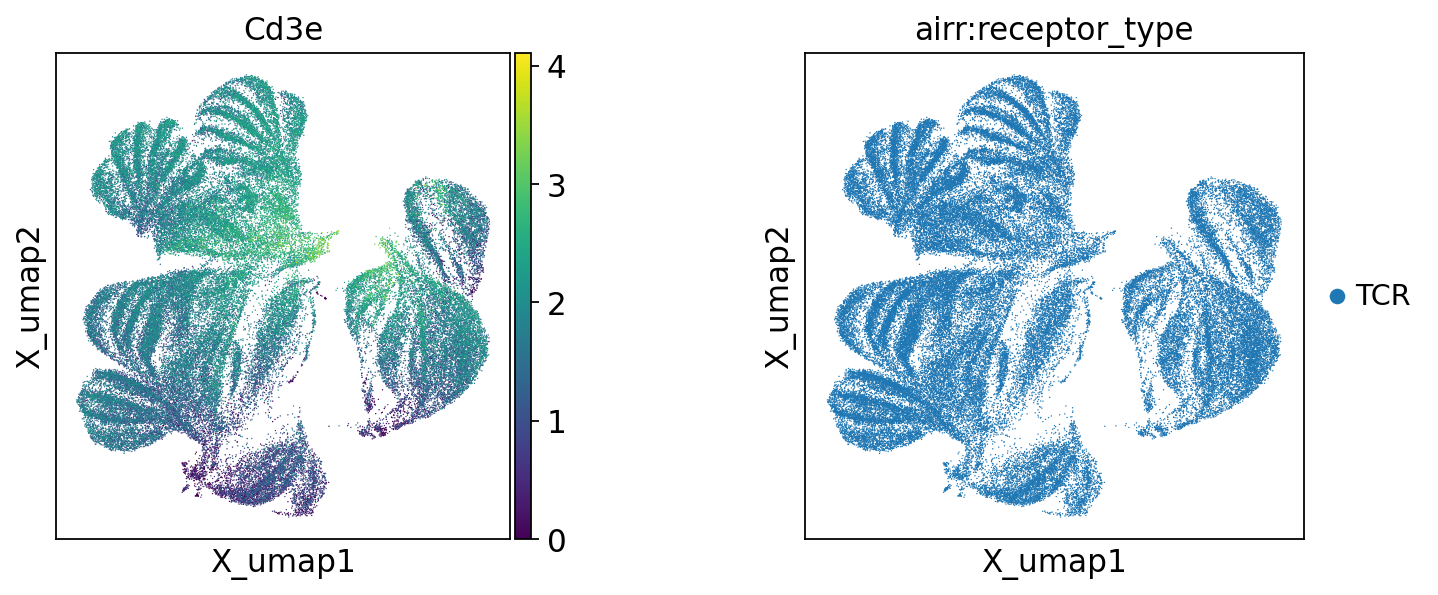

In [22]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={"wspace": 0.5})
mu.pl.embedding(mdata, basis="gex:umap", color=["Cd3e"], ax=ax0, show=False)
mu.pl.embedding(mdata, basis="gex:umap", color=["airr:receptor_type"], ax=ax1)

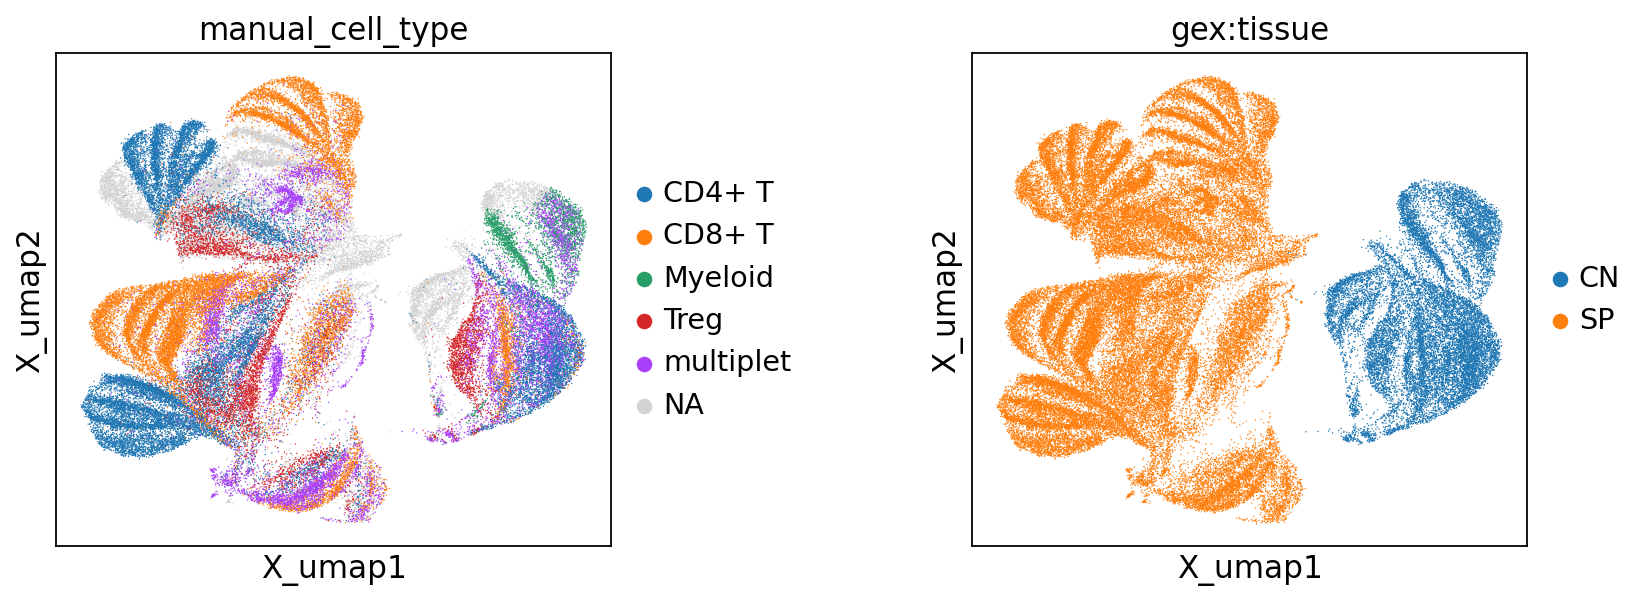

In [26]:
mu.pl.embedding(mdata, basis="gex:umap", color=['manual_cell_type','gex:tissue'],wspace = 0.5)

In [24]:
# mdata_new.write("common_GEX_TCR_mdata.h5mu")

# save filtered TCR table

In [27]:
mdata = mu.read("common_GEX_TCR_mdata.h5mu")
mdata

MuData object with n_obs × n_vars = 77660 × 33708
  obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'integrated_nn_res.2', 'seurat_clusters', 'level_2_clusters', 'manual_cell_type', 'run_num', 'sample'
  2 modalities
    gex:	77660 x 33708
      obs:	'mouse_id', 'date', 'tissue'
      uns:	'airr:receptor_type_colors', 'gex:tissue_colors', 'log1p', 'manual_cell_type_colors', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'
    airr:	77660 x 0
      obs:	'receptor_type', 'receptor_subtype', 'chain_pairing'
      uns:	'chain_indices'
      obsm:	'airr', 'chain_indices'

In [28]:
adata_tcr = mdata.mod['airr']
adata_tcr.obsm["airr"][0]

<Array [{c_call: 'TRBC2', cdr1: ..., ...}, ...] type='2 * {c_call: ?string,...'>

In [29]:
meta_DF = ir.get.airr(adata_tcr, ["cdr3_aa", "consensus_count", "v_call", "j_call"] ,  ('VJ_1', 'VDJ_1'))

# , "high_confidence","productive"

# ('VJ_1', 'VDJ_1', 'VJ_2', 'VDJ_2'), 

meta_DF.iloc[0:10,:]

,VJ_1_cdr3_aa,VJ_1_consensus_count,VJ_1_v_call,VJ_1_j_call,VDJ_1_cdr3_aa,VDJ_1_consensus_count,VDJ_1_v_call,VDJ_1_j_call
cell_id,,,,,,,,
AAACCAAAGGGGAGCT-1_0516_CNS,AAANNRIF,2086,TRAV4N-4,TRAJ31,ASSQERGGSQNTLY,4178,TRBV5,TRBJ2-4
AAACCAGCACGTAAAG-1_0516_CNS,ALSAGTGNTGKLI,2985,TRAV6-7-DV9,TRAJ37,ASSGGFSNERLF,3798,TRBV13-1,TRBJ1-4
AAACCATTCCTCCGGT-1_0516_CNS,AMREGTTGYQNFY,1363,TRAV16,TRAJ49,ASSQDDANTEVF,5141,TRBV5,TRBJ1-1
AAACCCATCAGTATCG-1_0516_CNS,AVRNYNVLY,4183,TRAV1,TRAJ21,TCSADLSNERLF,10187,TRBV1,TRBJ1-4
AAACCCCAGCCTAAGC-1_0516_CNS,AVSPNTGYQNFY,1115,TRAV9-4,TRAJ49,ASSLWTYAEQF,3547,TRBV15,TRBJ2-1
AAACCGTGTATCAGCG-1_0516_CNS,VLRNYNQGKLI,998,TRAV9N-2,TRAJ23,ASKTGGNTGQLY,5304,TRBV13-1,TRBJ2-2
AAACCTCCAAAGCTTC-1_0516_CNS,ALDAQGTGSKLS,13654,TRAV17,TRAJ58,ASGTGGSAETLY,6529,TRBV12-2+TRBV13-2,TRBJ2-3
AAACCTCCACCGTTTC-1_0516_CNS,ALERGYNVLY,5862,TRAV13-1,TRAJ21,ASSRVSGNYAEQF,9229,TRBV17,TRBJ2-1
AAACCTGTCCAGCCCT-1_0516_CNS,None,7569,TRAV4-3,TRAJ44,ASGETGGLYAEQF,3656,TRBV12-2+TRBV13-2,TRBJ2-1


In [32]:
meta_DF["VJ_1_v_call"].value_counts()

VJ_1_v_call
TRAV7D-2          2801
TRAV6D-6          2470
TRAV12D-3         2323
TRAV3N-3          2218
TRAV12-2          2195
                  ... 
TRAV15-2-DV6-2      43
TRAV13D-3           43
TRAV15-1-DV6-1      34
TRAV9D-4            19
TRAV18              13
Name: count, Length: 88, dtype: int64

In [ ]:
meta_DF.to_csv('primary_TCR.csv', index=True)